## Reading ECG exported measurements

`X` = 1852 cases x 2 features (varCycleLength + heartRate)

`Y` = 1852 cases x 1 label (1=normal,2=AF)

In [32]:
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import scale

fileName = "./MLexport.mat"

mat_contents = sio.loadmat(fileName)
    
X = mat_contents['X']
Y = mat_contents['Y']

# normalize by mean and std
X = scale( X, axis=0, with_mean=True, with_std=True, copy=True )

print(X.shape)

(1852, 2)


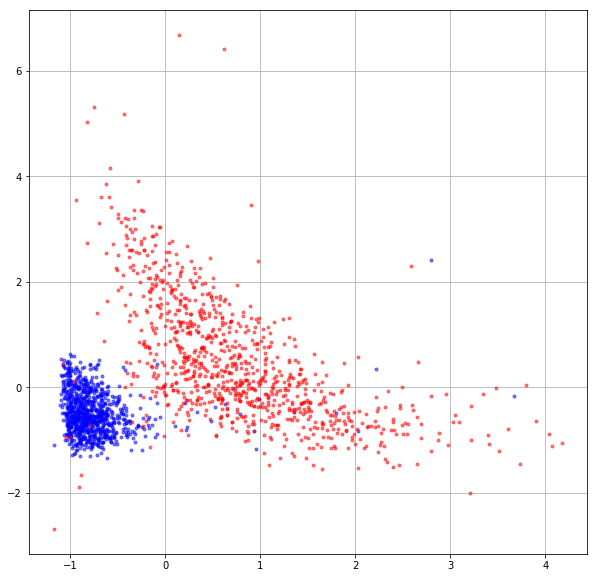

In [33]:
import matplotlib.pyplot as plt

idx1 = np.argwhere(Y==1)[:,0]
idx2 = np.argwhere(Y==2)[:,0]

fig,sub = plt.subplots(1,1,figsize=(10,10))

ax = sub
ax.plot(X[idx1,0],X[idx1,1],'b.',alpha=0.5)
ax.plot(X[idx2,0],X[idx2,1],'r.',alpha=0.5)
ax.grid()
#ax.set_xlim(0,0.4)
#ax.set_ylim(0,300)

plt.show()

## SVM classification using 2 features

The following code launches a linear SVM classifier on the two features `X[:,0]` and `X[:,1]`. The code should plot the training and testing samples, and the decision boundary. Use this to understand the influence of the hyper-parameter `c` and determine which relevant value to use for it.

In [47]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import math

#########################################
### YOUR TESTS HERE
models = [SVC(kernel='linear', C=1.0)]
#########################################

names = ['Linear SVM']

idx_rand = np.random.permutation(X.shape[0])
X_BK = X
X = X_BK[idx_rand,:]
Y = Y[idx_rand]

N_train = 300#math.floor(4 * X.shape[0] / 5)

Xtrain = X[:N_train,:]
Ytrain = Y[:N_train].ravel()

#Xtest = X[N_train:,:]
#Ytest = Y[N_train:].ravel()
Xtest = X[N_train:N_train+100,:]
Ytest = Y[N_train:N_train+100:].ravel()

#Xtrain = 
models = [clf.fit(Xtrain,Ytrain) for clf in models]


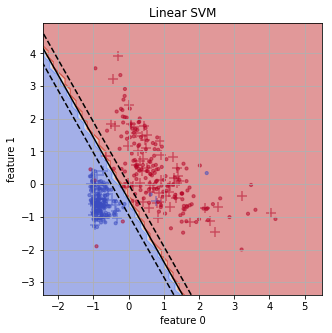

In [48]:
### 2D visualization

def make_meshgrid(x, y, h=.02):
    deltax = x.max() - x.min()
    deltay = y.max() - y.min()
    m = 0.25
    x_min, x_max = x.min() - m*deltax, x.max() + m*deltax
    y_min, y_max = y.min() - m*deltay, y.max() + m*deltay
    xx,yy = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
    return xx, yy

def visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest):
    xx, yy = make_meshgrid(Xtrain[:,0],Xtrain[:,1])
    
    fig,sub = plt.subplots(1,len(models),figsize=(5*len(models),5))
    
    if len(models)==1:
        sub = [sub]
    
    for clf, title, ax in zip(models, names, sub):

        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            Zc = 0
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]    
            Zc = 0.5
        Z = Z.reshape(xx.shape)
        ax.contour(xx,yy,Z,colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
        ax.contourf(xx,yy,Z>Zc,10,cmap=plt.cm.coolwarm,alpha=0.5)

        ax.scatter(Xtrain[:,0],Xtrain[:,1], c=Ytrain, cmap=plt.cm.coolwarm, s=10,alpha=0.5)
        ax.scatter(Xtest[:,0],Xtest[:,1],c=Ytest,cmap=plt.cm.coolwarm,marker='+',s=100,alpha=0.5)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.grid()
        ax.set_xlabel('feature 0')
        ax.set_ylabel('feature 1')
        ax.set_title(title)
    plt.show()
    
visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

Comment: 
We are trying to test the influence of the parameters C. 
It is easy to see that C influence the size of the margin. 

Reminder, here we try to choose the best parameters C for our train dataset. In the figure, it is impoortant to look at the dots which represent the train dataset. The goal is to have all the blue dots in the blue background, same for the red one (be careful of the overfitting)

You can't fint the optimal C value just by qualitative observation, we will try in the next step method to find the optimum parameters

### Q2.2
Fill in the following code to launch a **kernel RBF SVM classifier** (non-linear decision boundary) on the same two features. Use the same strategy to understand the influence of the hyper-parameters `c` and `gamma`. Why is this model more appropriate?

<span style="color:blue">
In the kernel RBF svm classifier, there is a new hyperparameter gamma.
The parameter gamma define the zone of influence of single training example. For a low value, the zone of influence will be large, and for high value, it will be close.
</span>

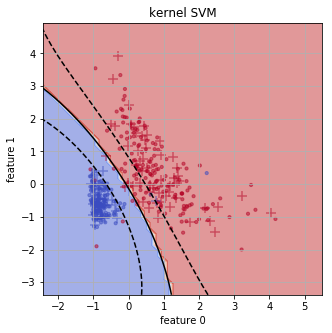

In [49]:
#########################################
### SOLUTION
models = [SVC(kernel='rbf', C=0.1 ,gamma=0.05)]
#########################################

names = ['kernel SVM']

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

### Q2.3 (Optionnal)
Use **cross-validation** with `GridSearchCV` to automatically determine the best hyper-parameters to use.

{'C': 0.1, 'gamma': 0.1}


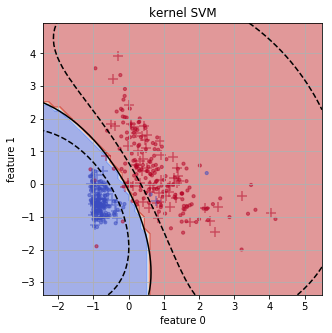

In [50]:
#########################################
### SOLUTION
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1]
    gammas = [0.001, 0.01, 0.1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

best_params_ = svc_param_selection(Xtrain, Ytrain, 5)
print(best_params_)
    
C_best = best_params_['C']
gamma_best = best_params_['gamma']
#########################################

models = [SVC(kernel='rbf', C=C_best ,gamma=gamma_best)]
names = ['kernel SVM']

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

<span style="color:blue">
Important to choose a good range of value for your parameters
Try first to find the order of matgnitude and then try other value in the same order of magnitude
</span>

### Q2.4
Extend your analysis to **other classification algorithms**: SVM polynomial (degree 3), nearest neighbors (`KNeighborsClassifier`), random forests (`RandomForestsClassifier`), neural network (`MLPClassifier`), etc.

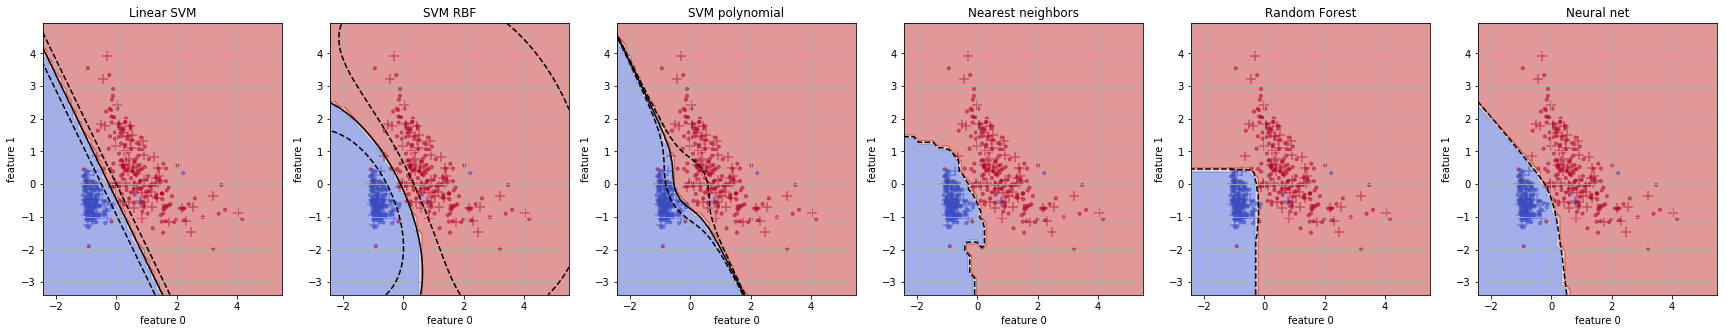

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#########################################
### SOLUTION
models = [
    SVC(kernel='linear', C=1.0),
    SVC(kernel='rbf',gamma=0.1,C=0.1),
    SVC(kernel='poly',degree=3,C=1.0),
    KNeighborsClassifier(3),
    RandomForestClassifier(max_depth=3, n_estimators=100, max_features='auto'),
    MLPClassifier(alpha=0.1,max_iter=1000)]
#########################################

names = (
        'Linear SVM',
        'SVM RBF',
        'SVM polynomial',
        'Nearest neighbors',
        'Random Forest',
        'Neural net')

models = [clf.fit(Xtrain,Ytrain) for clf in models]

visualizeOutput(models,Xtrain,Ytrain,Xtest,Ytest)

To compare the different classifiers, you can only use observations here. Some score, like accuracy, will be used next to compare them and to be raelly able to compare them each other.

### Q2.5
Fill in the following code to **evaluate the performance of the algorithms and visualize it**. What do you think?

<span style="color:blue">Globally, high performance, very comparable. You can play with the size of the training / testing (in particular, use few testing cases) to see how this generalizes or not.</span>

In [54]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

class LearningResults:
    def __init__(self):
        self.Ypred = []
        self.acc_test = []
        self.recall = []
        self.precision = []
        self.strategy = []
        self.names = []
    def __add__(s, o):
        self = LearningResults()
        for z in (s,o):
            for Ypred,acc_test,recall,precision,strategy,names in zip(z.Ypred,z.acc_test,z.recall,z.precision,z.strategy,z.names):
                self.Ypred.append(Ypred)
                self.acc_test.append(acc_test)
                self.recall.append(recall)
                self.precision.append(precision)
                self.strategy.append(strategy)
                self.names.append(names)
        return self

def computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,strategy,names):
    """Compute classifier performance and append to existing data
    """
    scoring = ['accuracy','precision','recall']
    results = LearningResults()
        
    for clf,n in zip(models,names):
        
        #########################################
        ### SOLUTION        
        clf.fit(Xtrain,Ytrain)
        Ypred = clf.predict(Xtest)
        #########################################

        Ypred = np.around( Ypred )
        results.Ypred.append( Ypred )
        results.acc_test.append( accuracy_score(Ytest,Ypred) )
        results.recall.append( recall_score(Ytest,Ypred) )
        results.precision.append( precision_score(Ytest,Ypred) )
        results.strategy.append( strategy )
        results.names.append( n )
        
    return results

results_2F = computePerformance(models,Xtrain,Ytrain,Xtest,Ytest,'2F',names)

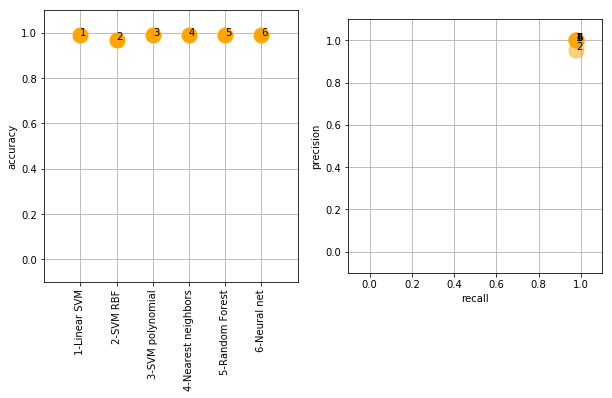

In [55]:
def plotPerformance(results):
    
    colorT = {'2F': 'orange', '12F': 'green', 'PLS': 'red' }

    fig,sub = plt.subplots(1,2,figsize=(10,5))
    
    N = len(results.names)
    
    ax = sub[0] ### accuracy (train,test)
    for i in range(0,N):
        ax.plot(i+1,results.acc_test[i],'.',color=colorT[results.strategy[i]],markersize=30)
        ax.text(i+1,results.acc_test[i],str(i+1),color='k')
    ax.set_xticks([i+1 for i in range(0,N)])
    xtick = [str(i+1)+'-'+n for i,n in zip(range(0,N),results.names)]
    ax.set_xticklabels(xtick,rotation=90)
    ax.set_xlim(0,N+1)
    ax.set_ylim(-0.1,1.1)
    ax.grid()
    ax.set_ylabel('accuracy')

    ax = sub[1] ### precision-recall (test)
    for i,st,x,y in zip(range(0,N),results.strategy,results.recall,results.precision):
        ax.plot(x,y,'.',alpha=0.5,markersize=30,color=colorT[st])
        ax.text(x,y,str(i+1),color='k')
    ax.set_xlim(-0.1,1.1)
    ax.set_ylim(-0.1,1.1)
    ax.set_aspect('equal')
    ax.grid()
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')

    plt.show()

plotPerformance(results_2F)